In [98]:
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
R = pd.read_csv('data.csv',index_col=0,parse_dates=True)
#convert the data which is in prices to returns
R = R.pct_change().dropna()
daily_rf_return = 0.0001337
R_new = R.copy()
R_new['risk_free'] = daily_rf_return
R_new = R_new.T.values
R = R.T.values


In [100]:
import numpy as np

def QIS(Sample, ddof=1):
    """
    Compute the Quadratic-Inverse Shrinkage (QIS) estimator for a given sample.
    Parameters:
    Sample (numpy.ndarray): A 2D array where rows represent the stocks and columns represent the time series.
    ddof (int, optional): Degrees of freedom correction for the sample mean. Default is 1: Mean is subtracted.
    Returns:
    numpy.ndarray: The QIS estimator of the covariance matrix.
    Notes:
    - The input sample is expected to be a NumPy array.
    - The function ensures the symmetry of the sample covariance matrix.
    - Eigenvalues are clipped to be non-negative.
    - The function uses a smoothing parameter for the shrinkage estimator.
    - The trace of the covariance matrix is preserved in the final estimator.
    """

    # Y is expected to be a NumPy array
    Sample = Sample.T
    N, p = Sample.shape  # Get dimensions of Y

    # Default setting: if k is None or NaN, set k = 1 (no de-mean)
    if ddof>=1:
        Sample=Sample -np.mean(Sample, axis=0)

    # Vars
    n = N - ddof   # Adjust effective sample size
    c = p / n   # Concentration ratio

    # Compute sample covariance matrix
    sample = np.matmul(Sample.T, Sample) / n
    sample = (sample + sample.T) / 2  # Ensure symmetry

    # Eigenvalue decomposition (use eigh for Hermitian matrix)
    lambda1, u = np.linalg.eigh(sample)
    lambda1 = np.clip(lambda1.real, a_min=0, a_max=None)  # Clip negative eigenvalues to 0

    # Compute Quadratic-Inverse Shrinkage estimator
    h = (min(c**2, 1/c**2)**0.35) / p**0.35  # Smoothing parameter

    # Inverse of (non-null) eigenvalues
    invlambda = 1 / lambda1[max(1, p - n + 1) - 1:p]

    # Calculate Lj and Lj_i (Differences of inverse eigenvalues)
    Lj = np.repeat(invlambda[:, np.newaxis], min(p, n), axis=1)
    Lj_i = Lj - Lj.T

    # Smoothed Stein shrinker (theta) and its conjugate (Htheta)
    Lj_squared = Lj * Lj
    theta = np.mean(Lj * Lj_i / (Lj_i * Lj_i + Lj_squared * h**2), axis=0)
    Htheta = np.mean(Lj * Lj * h / (Lj_i * Lj_i + Lj_squared * h**2), axis=0)
    Atheta2 = theta**2 + Htheta**2  # Squared amplitude

    # Shrink eigenvalues based on p and n
    if p <= n:
        delta = 1 / ((1 - c)**2 * invlambda + 2 * c * (1 - c) * invlambda * theta + c**2 * invlambda * Atheta2)
    else:
        delta0 = 1 / ((c - 1) * np.mean(invlambda))  # Shrinkage of null eigenvalues
        delta = np.concatenate((
            np.full(p - n, delta0), 
            1 / (invlambda * Atheta2)
        ))

    # Preserve the trace
    deltaQIS = delta * (np.sum(lambda1) / np.sum(delta))

    # Reconstruct covariance matrix
    sigmahat = np.matmul(u, np.matmul(np.diag(deltaQIS), u.T))

    return sigmahat


In [101]:

import numpy as np
from scipy.optimize import minimize
import pandas as pd
def D(x):
    x =x[:20]
    n=len(x) 
    H = np.sum(x**2) / (np.sum(x)**2)
    return 1 / (n * H)

def variance(w,Sigma,mu, gamma=0.1 ):
    return w.T @ Sigma @ w -gamma * (w.T @ mu)


def marko_boosted(Sigma, divers, mu, gamma=0.1 ):
    n = len(Sigma[0])
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},              # sum to 1
        {'type': 'ineq', 'fun': lambda w: D(w) - divers},            # diversification
    ]

    bounds = [(0, None)] * n  # long-only
    w0 = np.ones(n) / n

    obj = lambda w: variance(w, Sigma, mu, gamma)

    result = minimize(obj, w0, method='SLSQP', bounds=bounds,
                      constraints=constraints,
                      options={'disp': False})
    return result.x



In [102]:
# Parameters
window_size = 100 # e.g., past 30 days
horizon = 30       # e.g., next 7 days
T = R.shape[1]     # total number of days

tab_weights = []         # Weights after daily drift (before rebalance)
tab_returns = []         # Daily portfolio returns
current_weights = None   # Initialize

for i in range(0, R.shape[1] - window_size - horizon + 1, horizon):
    # Step 1: Compute weights for this 7-day period
    R_window = R[:, i : i + window_size]
    cov_matrix = QIS(R_window)
    A_extended = np.zeros((cov_matrix.shape[0] + 1, cov_matrix.shape[1] + 1))

# Copy original values
    A_extended[:cov_matrix.shape[0], :cov_matrix.shape[1]] = cov_matrix
    R_window_new = R_new[:, i : i + window_size]
    returns =R_window_new.mean(axis=1) 
    
    target_weights = np.array(marko_boosted(A_extended,0.7 ,returns,0.11))

    # Step 2: Simulate drift over the next `horizon` days
    current_weights = target_weights.copy()
    future_returns = R_new[:, i + window_size : i + window_size + horizon]  # shape (N, 7)

    for t in range(horizon):
        r = future_returns[:, t]  # return on day t
        tab_returns.append(np.dot(current_weights, r))
        if np.dot(current_weights, r) >10 :
            print(max(current_weights))

        # Portfolio value change
        values = current_weights * (1 + r)
        total = values.sum()
        current_weights = values / total
        tab_weights.append(current_weights)


C:\Users\hando\AppData\Local\Temp\ipykernel_35992\259624208.py:7: RuntimeWarning: invalid value encountered in scalar divide
  H = np.sum(x**2) / (np.sum(x)**2)


In [103]:

r_mean = np.mean(tab_returns)

vol_annual = np.std(tab_returns, ddof=1) * np.sqrt(365)
ret_annual = r_mean * 365
risk_free_rate = 0.05
sharpe_ratio = np.sqrt(365) * (r_mean - daily_rf_return / 365) / vol_annual

print(f"Annualized Return: {ret_annual:.4%}")
print(f"Annualized Volatility: {vol_annual:.4%}")
print(f"Sharpe Ratio: {sharpe_ratio*100:.4f}")


Annualized Return: 26.4556%
Annualized Volatility: 19.8089%
Sharpe Ratio: 6.9870


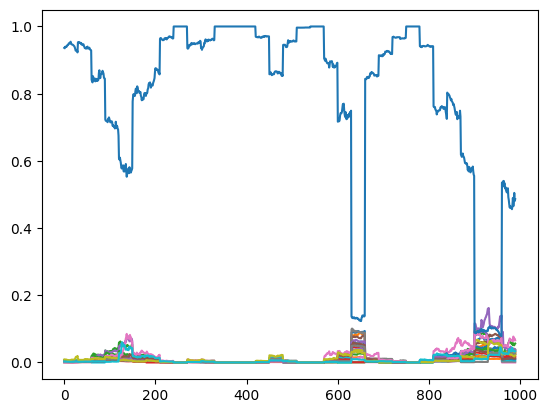

In [104]:
tab_weights = np.array(tab_weights)
plt.plot(tab_weights)

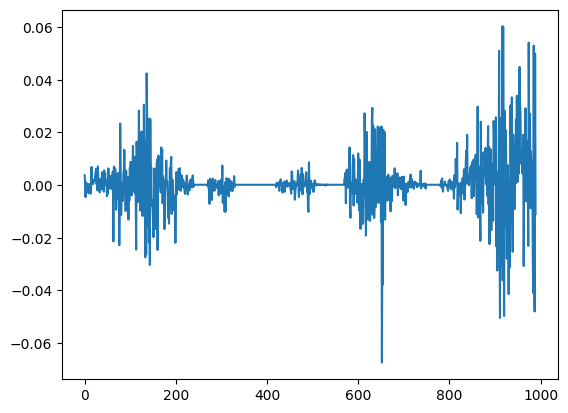

In [105]:
plt.plot(tab_returns)

In [106]:
import matplotlib.pyplot as plt

def plot_time_series_df(df, title="Portfolio Performance", ylabel="price ($)", figsize=(12, 5)):
    plt.figure(figsize=figsize)

    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    plt.xlabel("date")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df = pd.read_csv('data.csv', index_col=0, parse_dates=True)


In [107]:
selected = df.filter(like="bitcoin", axis=1)
for column in selected.columns:
    print(selected.index)


DatetimeIndex(['2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31',
               '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
               '2021-04-05', '2021-04-06',
               ...
               '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-24',
               '2024-03-25', '2024-03-26'],
              dtype='datetime64[ns]', name='date', length=1095, freq=None)


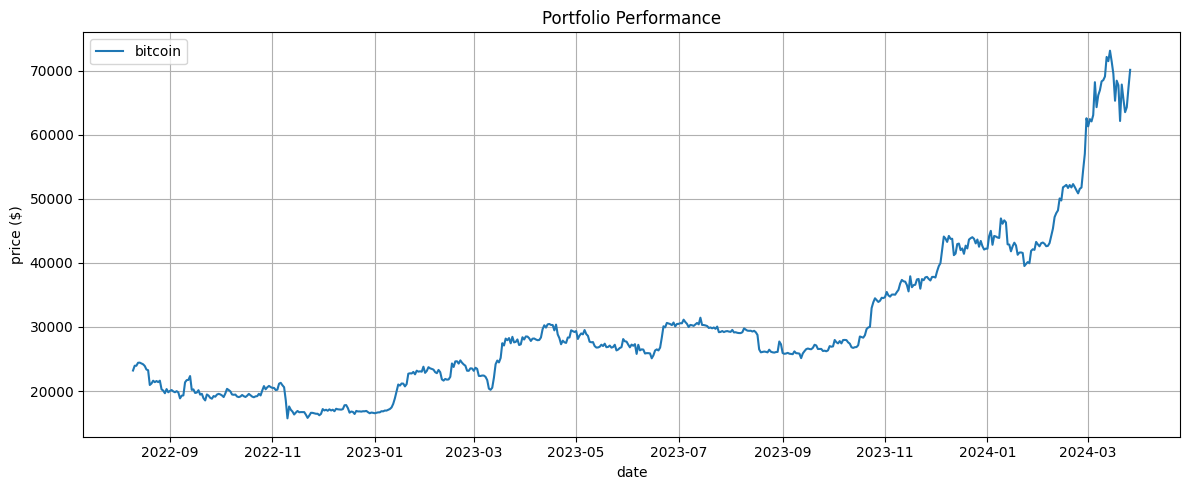

In [108]:
plot_time_series_df(selected[500:])

In [ ]:


def backtest_marko_boosted(method,R, R_new,window_size=100, horizon=30,gamma=0.1):
    # Parameters
    T = R.shape[1]     # total number of days

    tab_weights = []         # Weights after daily drift (before rebalance)
    tab_returns = []         # Daily portfolio returns
    current_weights = None   # Initialize

    for i in range(0, R.shape[1] - window_size - horizon + 1, horizon):
        
        if method =='equal_weighted':
            target_weights = np.ones(R.shape[0]+1) / (R.shape[0]+1)
        elif method == 'bitcoin':
            target_weights=np.zeros(R.shape[0]+1)
            target_weights[0] = 1
        elif method == 'cash' :
            target_weights = np.zeros(R.shape[0]+1)
            target_weights[-1] = 1
        else:
            R_window = R[:, i : i + window_size]
            cov_matrix = method(R_window)
            A_extended = np.zeros((cov_matrix.shape[0] + 1, cov_matrix.shape[1] + 1))
            A_extended[:cov_matrix.shape[0], :cov_matrix.shape[1]] = cov_matrix
            R_window_new = R_new[:, i : i + window_size]
            returns =R_window_new.mean(axis=1) 
            target_weights = np.array(marko_boosted(A_extended,0.7 , returns,gamma))
        
        

        # Step 2: Simulate drift over the next horizon days
        current_weights = target_weights.copy()
        future_returns = R_new[:, i + window_size : i + window_size + horizon]

        for t in range(horizon):
            r = future_returns[:, t]  # return on day t
            tab_returns.append(np.dot(current_weights, r))
            values = current_weights * ( 1+r)
            total = values.sum()
            current_weights = values / total
            tab_weights.append(current_weights)
    sharpe_ratio,vol_annual,ret_annual,wealth = indicator(np.array(tab_returns))
    indicator_df = pd.DataFrame({
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Volatility': vol_annual,
        'Annualized Return': ret_annual,
        'wealth' :wealth
    }, index=[0])
    return indicator_df, np.array(tab_weights), np.array(tab_returns)

In [110]:
print("Backtesting with QIS method:" , backtest_marko_boosted(QIS, R, R_new, window_size=100, horizon=30, gamma=0.1))

C:\Users\hando\AppData\Local\Temp\ipykernel_35992\259624208.py:7: RuntimeWarning: invalid value encountered in scalar divide
  H = np.sum(x**2) / (np.sum(x)**2)


NameError: name 'indicator' is not defined